# This notebook assess the predictions of our ML models on the initial test data and aims to explore any insights from the initial predictions

### We apply a threshold based on validation P-R curve analysis in this notebook

### Import the necessary libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import keras 
from keras.models import Sequential
from keras.layers import Dense 
import tensorflow
#from tensorflow.keras.utils import to_categorical
from keras import layers
#from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
from keras import backend as K
from keras.utils import np_utils

from tensorflow.keras.models import load_model

In [2]:
import seaborn as sns 

In [3]:
# whats in our dir 

%ls

 Volume in drive C is Windows
 Volume Serial Number is 4051-E7E7

 Directory of C:\Users\Nikhiel\Desktop\model_analysis - 2nd_gasgain_tuning

2023/02/04  02:03    <DIR>          .
2023/02/04  01:55    <DIR>          ..
2023/02/04  01:58    <DIR>          .ipynb_checkpoints
2023/01/22  17:12    <DIR>          __pycache__
2022/11/28  10:04         1ÿ459ÿ166 Analysis_of_nets(1)_updated.html
2022/11/28  21:35           800ÿ771 Analysis_of_nets.ipynb
2023/01/19  20:01           783ÿ827 Analysis_of_nets-UNORM_CNN.ipynb
2022/11/28  02:11           161ÿ352 ann1.h5
2022/11/06  00:42             2ÿ899 avgph.py
2022/11/28  02:14            72ÿ192 cnn_NET1.h5
2022/11/28  02:15           978ÿ448 cnn2_NET1.h5
2022/11/17  23:42         1ÿ125ÿ254 CNN-o2-models(5).html
2022/11/28  05:23           749ÿ761 Combining_sim_data.html
2023/02/04  01:54           934ÿ220 Initial_testset_ML_predictions.ipynb
2023/01/29  23:47           997ÿ448 Initial_testset_ML_predictions-ANN1.ipynb
2023/02/04  02:03         

###  Define function to produce an individual pulse height 

In [4]:
def single_ph(sigarray):
    #num_sigs = len(sigarray) for this function it will be one - single signal 
    adc = np.sum(sigarray, axis=0)
    timebin = np.arange(0,30,1)
    '''
    for i in range(30):
        
        avg = np.concatenate((np.array(sigarray[i]),
                             np.array(sigarray[i+30]),
                             np.array(sigarray[i+60])), axis=None).sum()/1
        m_adc.append(avg)
        timebin.append(i)
    '''
    #fig, ax = plt.subplots(figsize=(16, 7))
    #plt.figure(figsize=(16, 7))
    #plt.plot(timebin, m_adc, color="royalblue")
    #plt.scatter(timebin, m_adc, color="navy")
    plt.step(timebin, adc, color='royalblue')
    plt.ylabel("ADC", fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()

### load the initial test data 

In [5]:
test = pd.read_csv("test.csv")

In [6]:
test.head()

,AN00,AN01,AN02,AN03,AN04,AN05,AN06,AN07,AN08,AN09,...,BN21,BN22,BN23,BN24,BN25,BN26,BN27,BN28,BN29,label
0,10,8,10,11,10,10,20,63,68,42,...,15,15,14,13,13,13,12,12,12,0
1,89,122,65,40,30,26,23,22,19,18,...,14,13,11,11,12,11,14,11,11,0
2,11,12,10,13,12,13,12,12,14,15,...,10,11,9,11,8,9,13,10,10,0
3,30,46,29,22,19,20,38,50,39,37,...,11,9,8,11,9,7,10,9,9,0
4,16,20,16,15,12,12,12,11,11,11,...,31,29,25,28,37,34,30,25,32,1


### Modify the cell below if using an ANN 

In [7]:
# Get the signals and labels as arrays 
signals = np.array(test.iloc[:, :90])
labels = np.array(test.label)


In [8]:
labels_ohe = keras.utils.np_utils.to_categorical(labels, 2)

## Now we get the signals and assign to "sigs" variable. Modify the cell below depending on the model used and if normalization and or reshaping is needed or not

In [9]:
sigs = signals.reshape(len(test), 3, 30)/1023


## load the keras model 

In [10]:
mod = load_model('cnn2_NET1.h5')

In [11]:
mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convol2D (Conv2D)           (None, 3, 30, 120)        1200      
                                                                 
 maxpool (MaxPooling2D)      (None, 1, 10, 120)        0         
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
 hidden_layer (Dense)        (None, 64)                76864     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 Dense-output (Dense)        (None, 2)                 1

## Predict on the test data using model 

In [12]:
probs = mod.predict(sigs)

## Get the corresponding predictions 

In [13]:


# Note we must apply the prob threshold here   
# For our CNN-2 model this is = 0.949

preds = np.zeros(len(test))


preds[probs[:,1]>=0.949] = 1      




#preds = np.argmax(probs, axis=1)

## Confusion matrix 

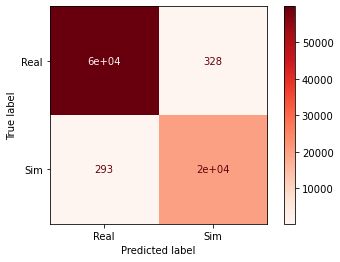

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    labels, preds, cmap='Reds', display_labels=['Real', 'Sim']
)
plt.show()

## Performance metrics 

In [15]:
from sklearn import metrics

In [16]:
Prec = metrics.precision_score(labels, preds, pos_label=1)
Sens = metrics.recall_score(labels, preds, pos_label=1)
Spec = metrics.recall_score(labels, preds, pos_label=1)
F1 = metrics.f1_score(labels, preds, pos_label=1)
Acc = metrics.accuracy_score(labels, preds)


print('Precision = {}'.format(Prec))
print('Sensitivity = {}'.format(Sens))
print('Specificity = {}'.format(Spec))
print('F1 = {}'.format(F1))
print('Accuracy = {}'.format(Acc))

Precision = 0.9837374188110467
Sensitivity = 0.985447501738353
Specificity = 0.985447501738353
F1 = 0.9845917177381338
Accuracy = 0.9922634175512035


In [17]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(labels, preds, labels=[0, 1]).ravel()

t_Spec = tn/(tn + fp)
t_missrate = fn/(fn + tp) 
print('Specificity = {}'.format(t_Spec))
print('Miss rate / FNR  = {}'.format(t_missrate))


Specificity = 0.9945455150164633
Miss rate / FNR  = 0.014552498261646965


In [18]:
confusion_matrix(labels, preds, labels=[0, 1])

array([[59806,   328],
       [  293, 19841]], dtype=int64)

## Misclassifications 

In [19]:
# find out where misclassifications occur (indices)

misclass = np.where(labels!=preds)[0]
misclass_probs = probs[misclass]

misclass_labs = labels[misclass]
misclass_preds = preds[misclass]

misclass_sigs = signals[misclass]       


In [20]:
#df_misclass = pd.concat([misclass_sigs, misclass_probs, misclass_preds, misclass_labs], axis=1)

## False negatives 


In [21]:
# Here the preds = 0 but the labels = 1

# This is a subset of the misclass 

# where in the misclassified labels is the labels 1 
fn_locs = np.where(misclass_labs == 1)[0]  # these are locations of truly sim sigs 

misclass_labsfn = misclass_labs[fn_locs] 
misclass_predfn = misclass_preds[fn_locs]

misclass_probsfn = misclass_probs[fn_locs]

misclass_sigsfn = misclass_sigs[fn_locs]

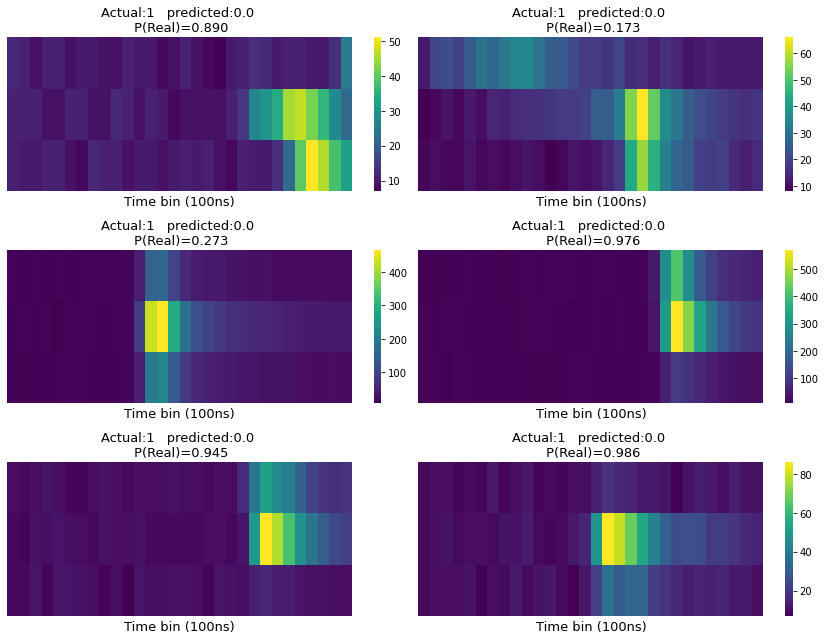

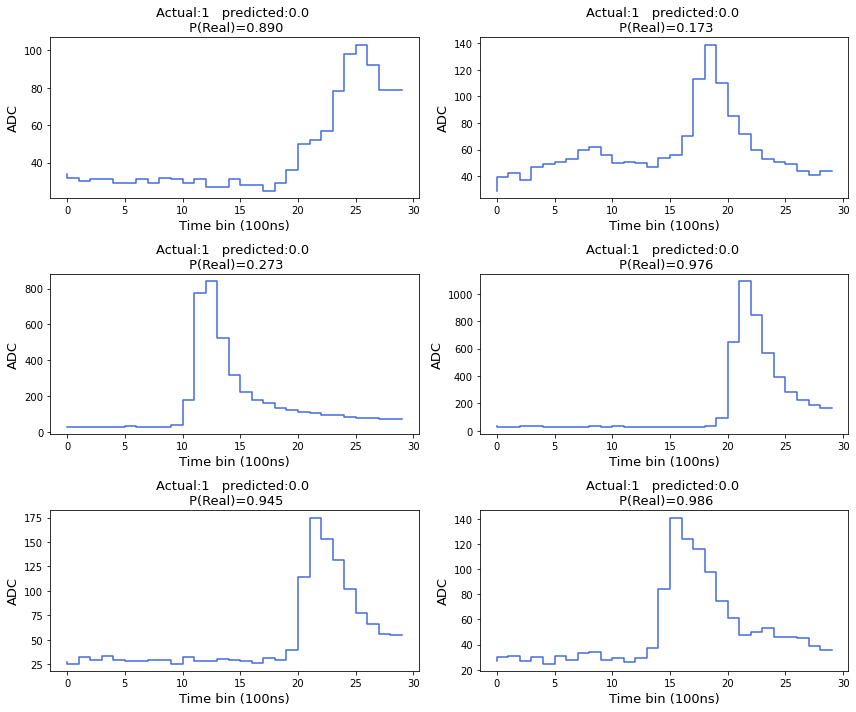

In [22]:
plt.figure(figsize=(12, 9))
six = 6
nset = 0
k = six*nset
for j in range(1,7):
    
    plt.subplot(3,2,j)
    #plt.figure(figsize=(10, 4))
    sns.heatmap(misclass_sigsfn[j+k].reshape(3,30), cmap='viridis', xticklabels=False, yticklabels=False, cbar=True)
    #plt.title("\nTOTAL ADC SUM = {}\n".format(sdf1.ADCSUM[j+50]))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()
    
plt.show()


plt.figure(figsize=(12, 10))
for j in range(1,7):
    
    plt.subplot(3,2,j)
    
    single_ph(misclass_sigsfn[j+k].reshape(3,30))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.tight_layout()
    
plt.show()
    

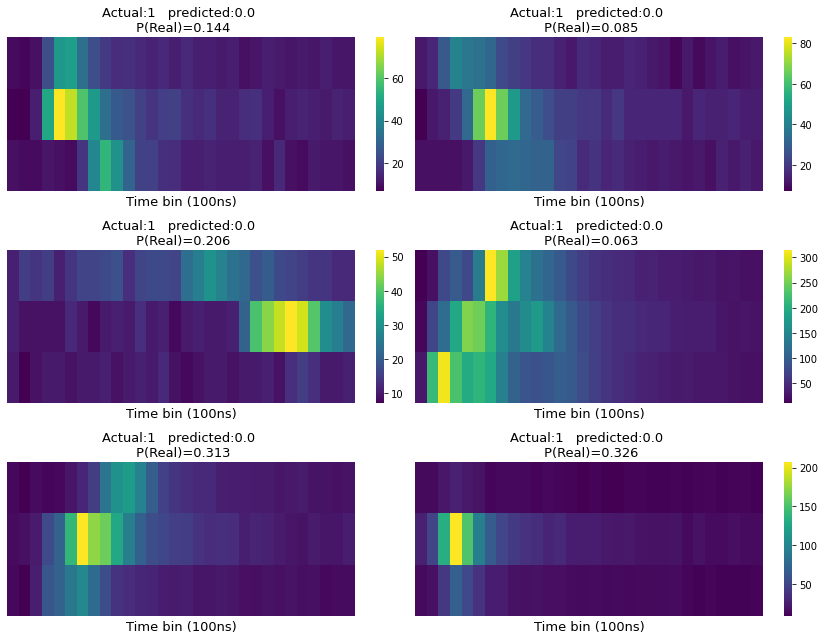

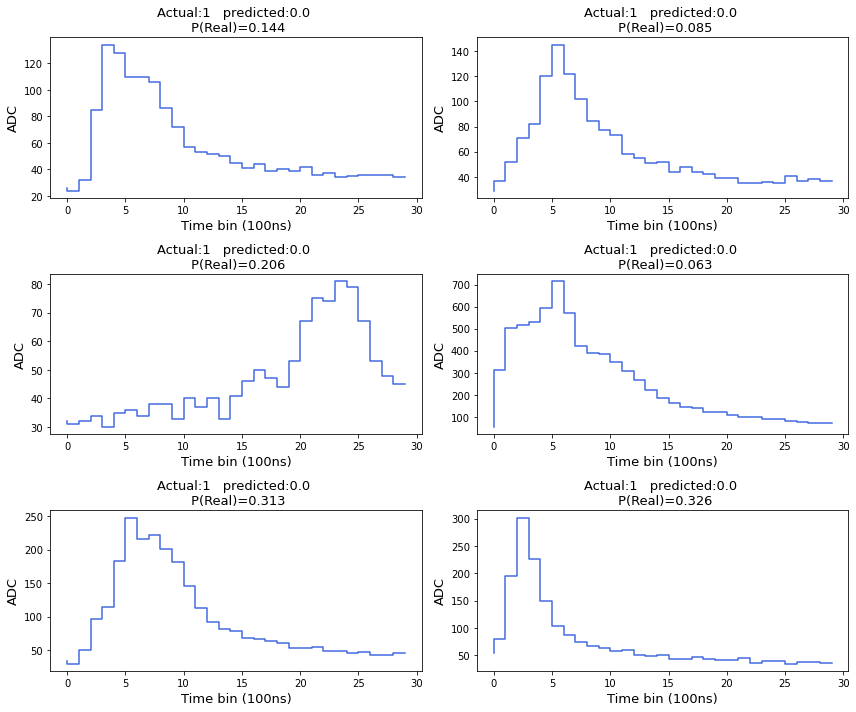

In [23]:
plt.figure(figsize=(12, 9))
six = 6
nset = 1
k = six*nset
for j in range(1,7):
    
    plt.subplot(3,2,j)
    #plt.figure(figsize=(10, 4))
    sns.heatmap(misclass_sigsfn[j+k].reshape(3,30), cmap='viridis', xticklabels=False, yticklabels=False, cbar=True)
    #plt.title("\nTOTAL ADC SUM = {}\n".format(sdf1.ADCSUM[j+50]))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()
    
plt.show()


plt.figure(figsize=(12, 10))
for j in range(1,7):
    
    plt.subplot(3,2,j)
    
    single_ph(misclass_sigsfn[j+k].reshape(3,30))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.tight_layout()
    
plt.show()
    

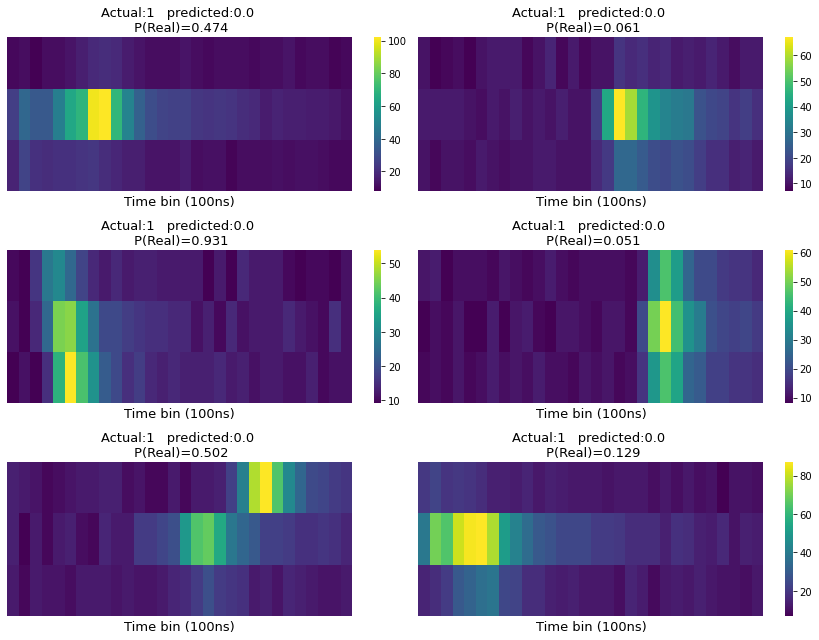

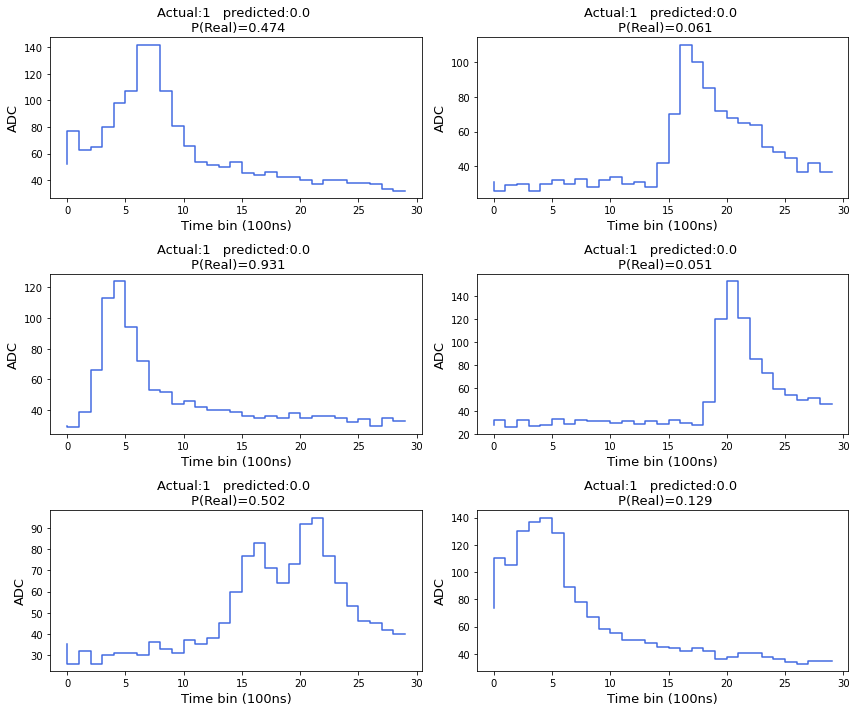

In [24]:
plt.figure(figsize=(12, 9))
six = 6
nset = 2
k = six*nset
for j in range(1,7):
    
    plt.subplot(3,2,j)
    #plt.figure(figsize=(10, 4))
    sns.heatmap(misclass_sigsfn[j+k].reshape(3,30), cmap='viridis', xticklabels=False, yticklabels=False, cbar=True)
    #plt.title("\nTOTAL ADC SUM = {}\n".format(sdf1.ADCSUM[j+50]))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()
    
plt.show()


plt.figure(figsize=(12, 10))
for j in range(1,7):
    
    plt.subplot(3,2,j)
    
    single_ph(misclass_sigsfn[j+k].reshape(3,30))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.tight_layout()
    
plt.show()
    

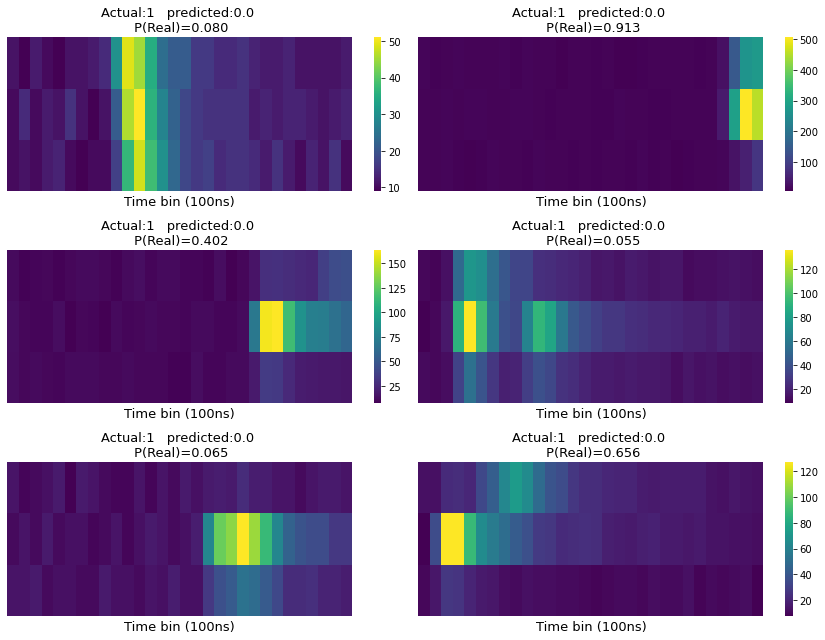

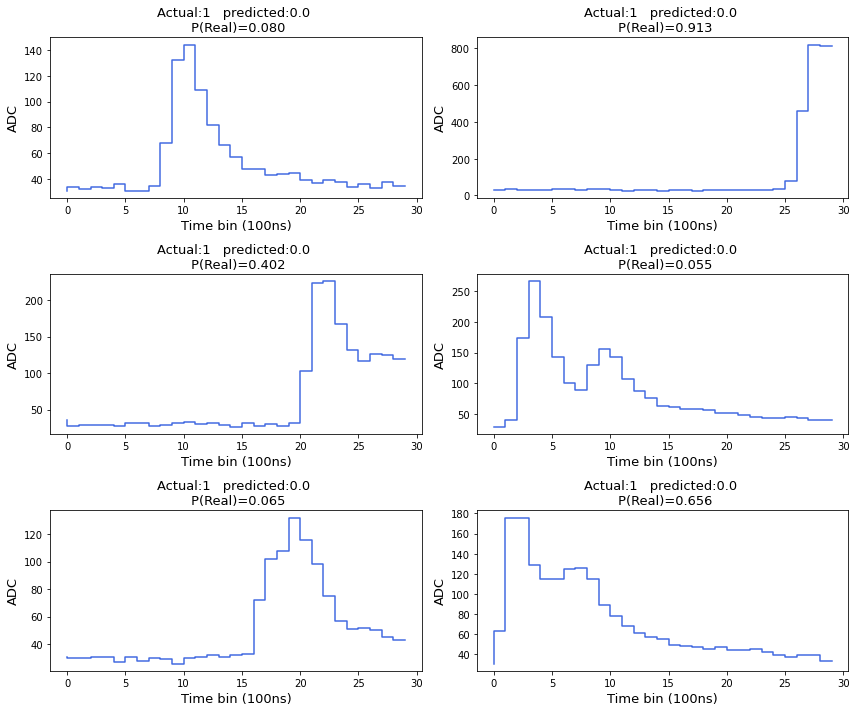

In [25]:
plt.figure(figsize=(12, 9))
six = 6
nset = 3
k = six*nset
for j in range(1,7):
    
    plt.subplot(3,2,j)
    #plt.figure(figsize=(10, 4))
    sns.heatmap(misclass_sigsfn[j+k].reshape(3,30), cmap='viridis', xticklabels=False, yticklabels=False, cbar=True)
    #plt.title("\nTOTAL ADC SUM = {}\n".format(sdf1.ADCSUM[j+50]))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()
    
plt.show()


plt.figure(figsize=(12, 10))
for j in range(1,7):
    
    plt.subplot(3,2,j)
    
    single_ph(misclass_sigsfn[j+k].reshape(3,30))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.tight_layout()
    
plt.show()
    

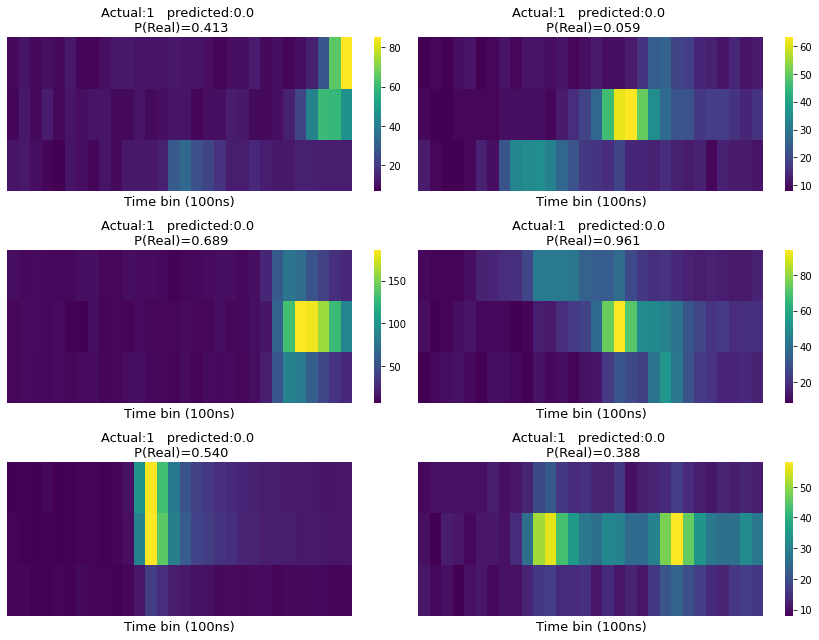

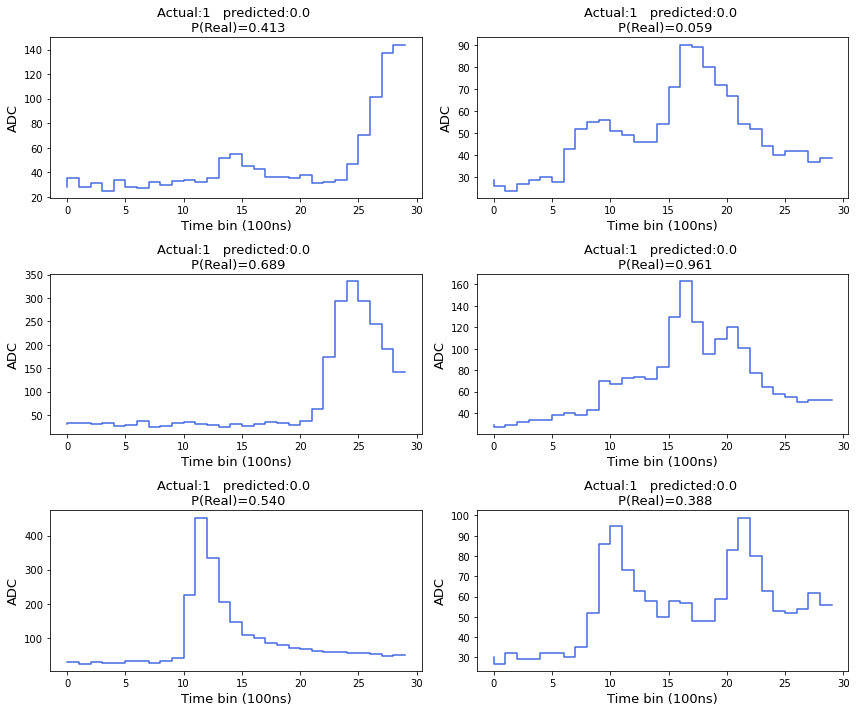

In [26]:
plt.figure(figsize=(12, 9))
six = 6
nset = 5
k = six*nset
for j in range(1,7):
    
    plt.subplot(3,2,j)
    #plt.figure(figsize=(10, 4))
    sns.heatmap(misclass_sigsfn[j+k].reshape(3,30), cmap='viridis', xticklabels=False, yticklabels=False, cbar=True)
    #plt.title("\nTOTAL ADC SUM = {}\n".format(sdf1.ADCSUM[j+50]))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()
    
plt.show()


plt.figure(figsize=(12, 10))
for j in range(1,7):
    
    plt.subplot(3,2,j)
    
    single_ph(misclass_sigsfn[j+k].reshape(3,30))
    plt.title("Actual:{}   predicted:{} \n P(Real)={:.3f}".format(misclass_labsfn[j+k], 
                                                              misclass_predfn[j+k], 
                                                              misclass_probsfn[j+k][0]), fontsize=13)
    plt.tight_layout()
    
plt.show()
    

## False Positives 

In [27]:
# Here the preds = 1 but the labels = 0  ie. these are real sigs that are wrongly predicted as sim 

# This is a subset of the misclass 

# where in the misclassified labels is the labels 0 
fp_locs = np.where(misclass_labs == 0)[0]  # these are locations of truly sim sigs 

misclass_labsfp = misclass_labs[fp_locs] 
misclass_predfp = misclass_preds[fp_locs]

misclass_probsfp = misclass_probs[fp_locs]

misclass_sigsfp = misclass_sigs[fp_locs]

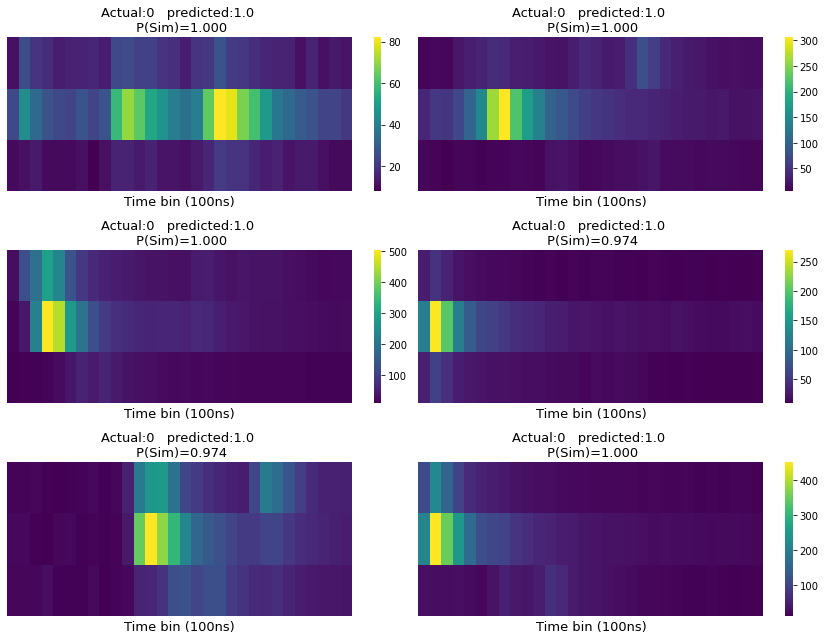

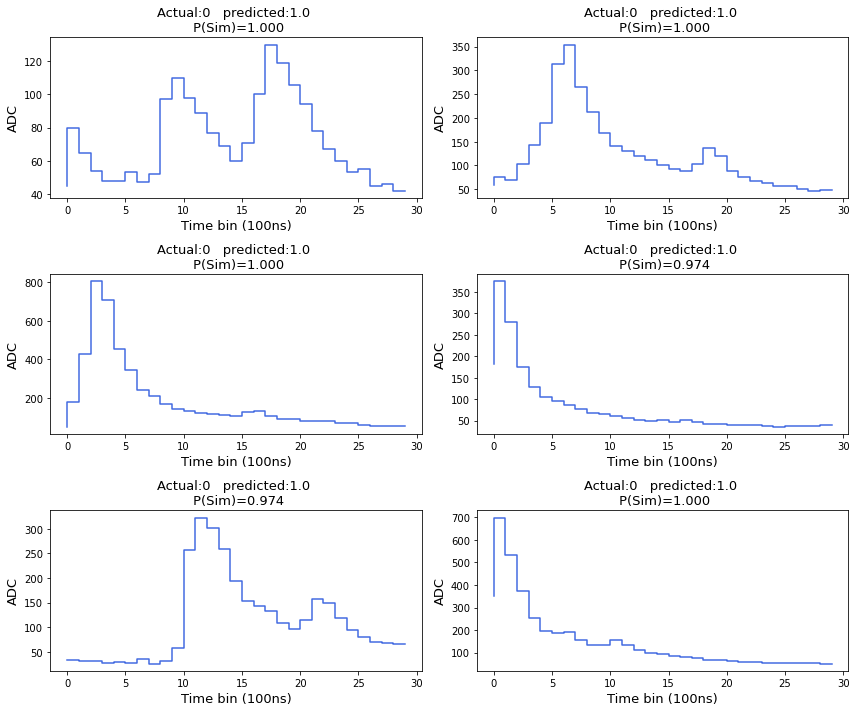

In [28]:
plt.figure(figsize=(12, 9))
six = 6
nset = 0
k = six*nset
for j in range(1,7):
    
    plt.subplot(3,2,j)
    #plt.figure(figsize=(10, 4))
    sns.heatmap(misclass_sigsfp[j+k].reshape(3,30), cmap='viridis', xticklabels=False, yticklabels=False, cbar=True)
    #plt.title("\nTOTAL ADC SUM = {}\n".format(sdf1.ADCSUM[j+50]))
    plt.title("Actual:{}   predicted:{} \n P(Sim)={:.3f}".format(misclass_labsfp[j+k], 
                                                              misclass_predfp[j+k], 
                                                              misclass_probsfp[j+k][1]), fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()
    
plt.show()


plt.figure(figsize=(12, 10))
for j in range(1,7):
    
    plt.subplot(3,2,j)
    
    single_ph(misclass_sigsfp[j+k].reshape(3,30))
    plt.title("Actual:{}   predicted:{} \n P(Sim)={:.3f}".format(misclass_labsfp[j+k], 
                                                              misclass_predfp[j+k], 
                                                              misclass_probsfp[j+k][1]), fontsize=13)
    plt.tight_layout()
    
plt.show()
    

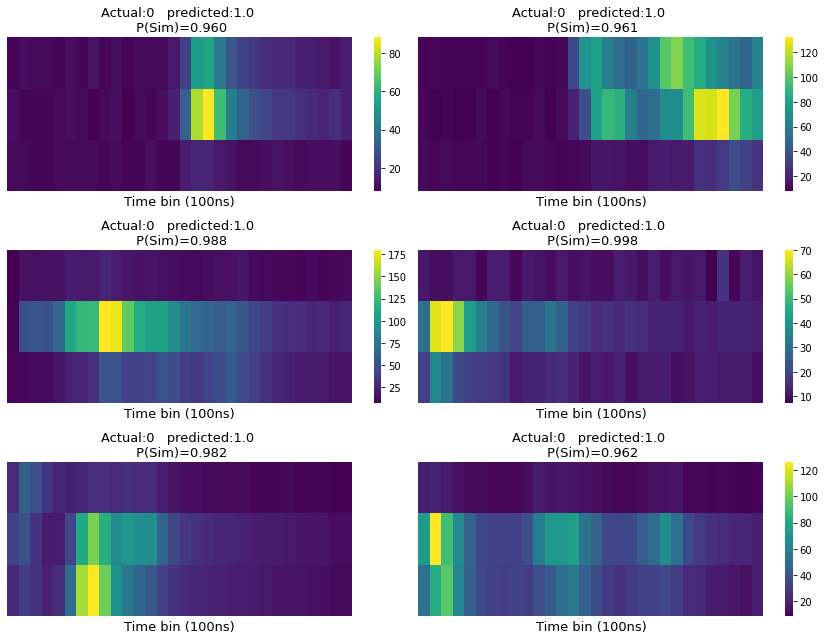

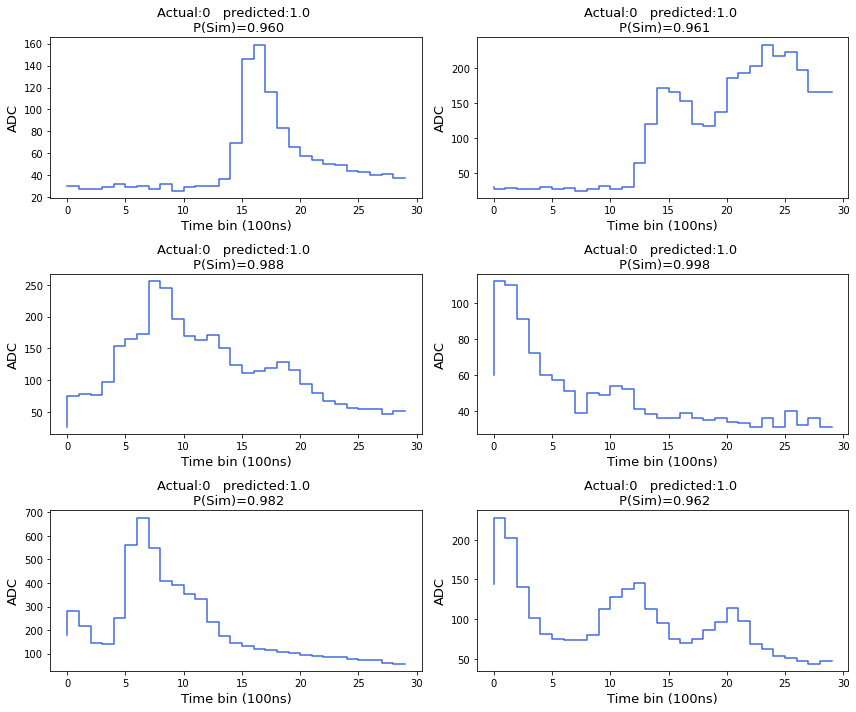

In [29]:
plt.figure(figsize=(12, 9))
six = 6
nset = 1
k = six*nset
for j in range(1,7):
    
    plt.subplot(3,2,j)
    #plt.figure(figsize=(10, 4))
    sns.heatmap(misclass_sigsfp[j+k].reshape(3,30), cmap='viridis', xticklabels=False, yticklabels=False, cbar=True)
    #plt.title("\nTOTAL ADC SUM = {}\n".format(sdf1.ADCSUM[j+50]))
    plt.title("Actual:{}   predicted:{} \n P(Sim)={:.3f}".format(misclass_labsfp[j+k], 
                                                              misclass_predfp[j+k], 
                                                              misclass_probsfp[j+k][1]), fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()
    
plt.show()


plt.figure(figsize=(12, 10))
for j in range(1,7):
    
    plt.subplot(3,2,j)
    
    single_ph(misclass_sigsfp[j+k].reshape(3,30))
    plt.title("Actual:{}   predicted:{} \n P(Sim)={:.3f}".format(misclass_labsfp[j+k], 
                                                              misclass_predfp[j+k], 
                                                              misclass_probsfp[j+k][1]), fontsize=13)
    plt.tight_layout()
    
plt.show()
    

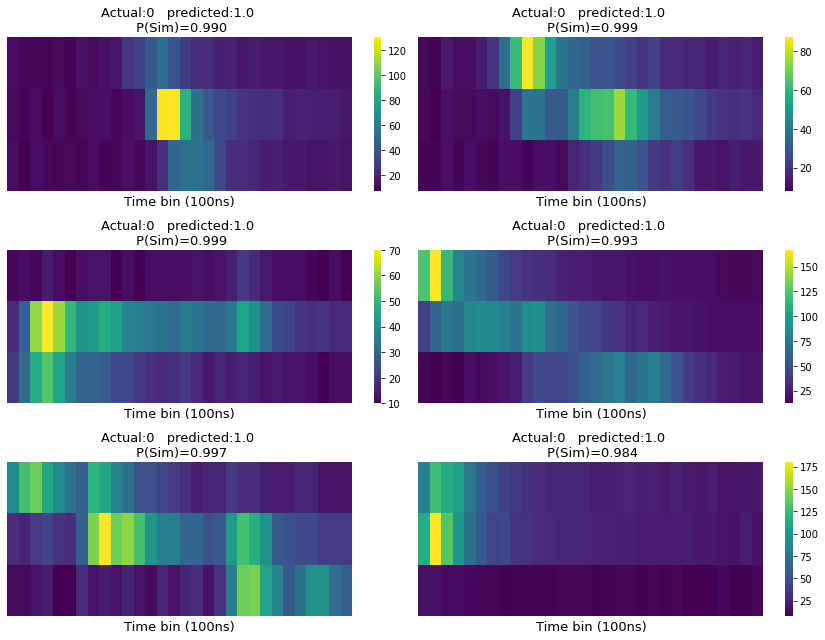

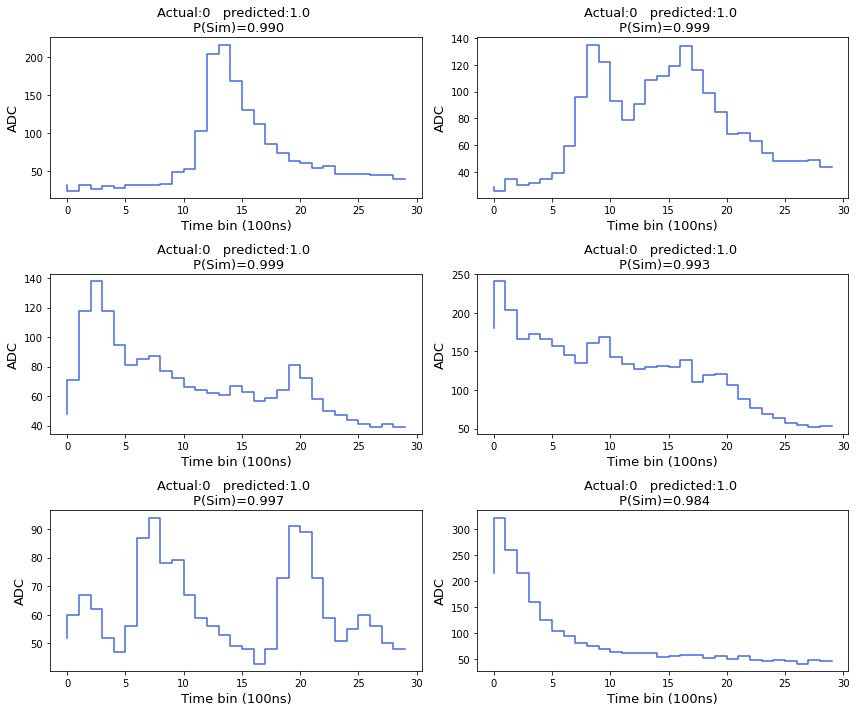

In [30]:
plt.figure(figsize=(12, 9))
six = 6
nset = 2
k = six*nset
for j in range(1,7):
    
    plt.subplot(3,2,j)
    #plt.figure(figsize=(10, 4))
    sns.heatmap(misclass_sigsfp[j+k].reshape(3,30), cmap='viridis', xticklabels=False, yticklabels=False, cbar=True)
    #plt.title("\nTOTAL ADC SUM = {}\n".format(sdf1.ADCSUM[j+50]))
    plt.title("Actual:{}   predicted:{} \n P(Sim)={:.3f}".format(misclass_labsfp[j+k], 
                                                              misclass_predfp[j+k], 
                                                              misclass_probsfp[j+k][1]), fontsize=13)
    plt.xlabel("Time bin (100ns)", fontsize=13)
    plt.tight_layout()
    
plt.show()


plt.figure(figsize=(12, 10))
for j in range(1,7):
    
    plt.subplot(3,2,j)
    
    single_ph(misclass_sigsfp[j+k].reshape(3,30))
    plt.title("Actual:{}   predicted:{} \n P(Sim)={:.3f}".format(misclass_labsfp[j+k], 
                                                              misclass_predfp[j+k], 
                                                              misclass_probsfp[j+k][1]), fontsize=13)
    plt.tight_layout()
    
plt.show()
    

##  Pulse height reconstruction from misclassifications 

In [31]:
df_Fn = pd.DataFrame(misclass_sigsfn)

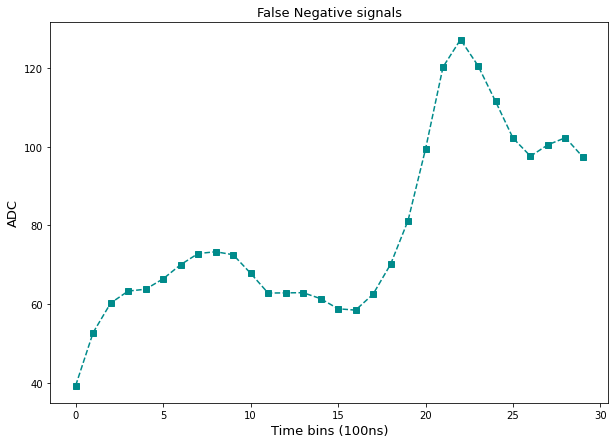

In [32]:
from avgph import *

tfn, adc_fn = pharray(df_Fn)

plt.figure(figsize=(10, 7))
plt.plot(tfn, adc_fn, marker='s', color='darkcyan', linestyle='--')
plt.xlabel("Time bins (100ns)", fontsize=13)
plt.ylabel("ADC", fontsize=13)
plt.title("False Negative signals", fontsize=13)
plt.show()

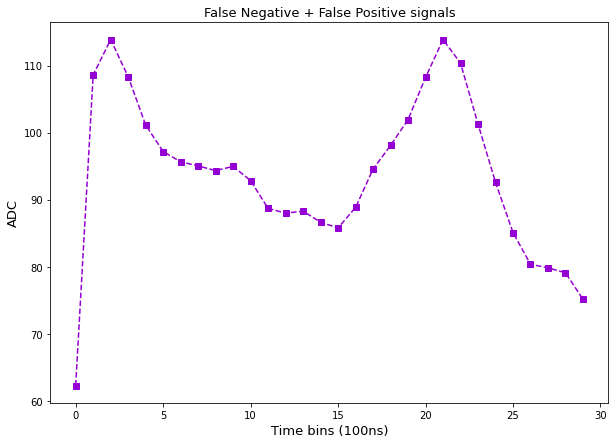

In [33]:
tfmc, adc_mc = pharray(pd.DataFrame(misclass_sigs))

plt.figure(figsize=(10, 7))
plt.plot(tfmc, adc_mc, marker='s', color='darkviolet', linestyle='--')
plt.xlabel("Time bins (100ns)", fontsize=13)
plt.ylabel("ADC", fontsize=13)
plt.title("False Negative + False Positive signals", fontsize=13)
plt.show()